# CLONE FOR DEBUGGING - Long-only with 2 x mean rev - Polygon
- 

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [96]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType  # NEW
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 1h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

# Which lending reserves we are using for supplying/borrowing assets
# NEW
LENDING_RESERVES = [
   (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
   (ChainId.polygon, LendingProtocolType.aave_v3, "USDC.e"),
]

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.8

# Start with this amount of USD
INITIAL_DEPOSIT = 50_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.h1

#
# Strategy thinking specific parameter
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 900

# ATR multiplier for stop loss                   
ATRmult = 1.5

# Moving average 
# How many candles to smooth out for Bollinger band's middle line
EMA_CANDLE_COUNT = 20  

TREND_EMA = 800


# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 10

# RSI must be below this value to open a new position
RSI_THRESHOLD = 25

# RSI must be above this value to open a new position
RSI_THRESHOLD_SHORT = 52

MFI_THRESHOLD = 40

# Backtest range
START_AT = datetime.datetime(2023, 1, 1)
START_AT_DATA = datetime.datetime(2022, 9, 1) #This is only for Binance data

# Backtest range
END_AT = datetime.datetime(2023, 1, 20)

# Stop loss relative to the mid price during the time when the position is opened
# If the price drops below this level, trigger a stop loss
#STOP_LOSS_PCT = 0.96

# What is the trailing stop loss level, this trails the most recent candle close price
TRAILING_STOP_LOSS_PCT = 0.99

TRAILING_STOP_LOSS_ACTIVATION_LEVEL = 1.003

# Take profit percentage
TAKE_PROFIT_PCT = 1.05

# Leverage ratio
LEVERAGE = 1.5

In [97]:
# Binance data 

#from tradeexecutor.utils.binance import create_binance_universe

#universe = create_binance_universe(
#    ["ETHUSDT"],
#    CANDLE_TIME_BUCKET,
#    STOP_LOSS_TIME_BUCKET,
#    START_AT_DATA,
#    END_AT,
#    include_lending=True
#)

#print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded

In [98]:
from typing import List, Dict

from pandas_ta import bbands, volume
from pandas_ta.volatility import atr
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi
from pandas_ta.volume import mfi

from tradingstrategy.universe import Universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager

bb_trade = False

def decide_trades(
    timestamp: pd.Timestamp,
    strategy_universe: TradingStrategyUniverse,
    state: State,
    pricing_model: PricingModel,
    cycle_debug_data: Dict
)-> List[TradeExecution]:
    
    global bb_trade
  
    universe = strategy_universe.universe

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    moving_average = ema(close_prices, length=EMA_CANDLE_COUNT)
    trend_ema = ema(close_prices, length=TREND_EMA)
    
    # trend_moving_average = ema(close_prices, length=TREND_EMA_CANDLE_COUNT)
    
    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]
    previous_rsi = rsi(close_prices, length=RSI_LENGTH)[-2]
    
    current_mfi = mfi(candles["high"], candles["low"], candles["close"], candles["volume"], length=14).iloc[-1]
    previous_mfi = mfi(candles["high"], candles["low"], candles["close"], candles["volume"], length=14).iloc[-2]
    third_last_mfi = mfi(candles["high"], candles["low"], candles["close"], candles["volume"], length=14).iloc[-3] 

    trades = []

    if moving_average is None or trend_ema is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting buffer yet.
        return trades
    

    price_close = close_prices.iloc[-1]
    previous_low = candles["low"].iloc[-2]

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    # Calculate wider Bollinger Bands using the typical 20-day SMA and 2 standard deviations 
    bollinger_bands_wide = bbands(close_prices, length=20, std=2)
    wide_bb_upper = bollinger_bands_wide["BBU_20_2.0"]
    wide_bb_lower = bollinger_bands_wide["BBL_20_2.0"]

    # Initialize variables
    lowest20 = 0 
    previous_lowest20 = 0
    stoploss_price_long = None

    big_drop = (close_prices.iloc[-2] / close_prices.iloc[-1]) > 1.02


    # Calculate ATR based stop loss 
    atr_stop = atr(candles["high"], candles["low"], close_prices, length=14).iloc[-1] * ATRmult

    # Iterate over the data to find the highest price in the last 20 candles
    for i in range(len(candles)):
        if i >= 19:  # Ensure there are at least 20 candles to look back
            # Calculate the lowest low of the past 20 candles excluding the latest candle
            if i < len(candles) - 1:  # Exclude the latest candle
                previous_lowest20 = candles['low'][i-19:i+1].min()
    
    # previous_lowest20 = candles['low'][-20:-1].min()

    # assert my_lowest_20 == lowest20
    
    if bb_trade == False and not position_manager.is_any_open():
        retest_trade = False
    
    ### LONGING
    if not position_manager.is_any_long_position_open():
        # Open long positions based on trading logic
    
        # Bollinger Bands mean rev - Entry Logic
        if (price_close < wide_bb_lower.iloc[-1]) and (current_rsi < RSI_THRESHOLD) and (price_close > trend_ema.iloc[-1]) and not big_drop:
            amount = cash * POSITION_SIZE
            entry_price = price_close
            STOP_LOSS = entry_price - atr_stop
            bb_trade = True
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_usd=STOP_LOSS, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)


        # Previous lowest retested - Entry Logic
        if ((third_last_mfi < 30) and (current_mfi > previous_mfi) and (previous_mfi > third_last_mfi) and (current_rsi > previous_rsi) and (current_rsi > 35)) or ((close_prices.iloc[-2] < previous_lowest20) and (price_close > close_prices.iloc[-2])) or ((price_close > previous_lowest20) and (candles["low"].iloc[-1] < previous_lowest20) and (candles["open"].iloc[-1] > price_close)) and bb_trade==False: #(current_mfi > MFI_THRESHOLD) and 
            amount = cash * POSITION_SIZE
            entry_price = price_close
            STOP_LOSS = entry_price - atr_stop
            retest_trade = True
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_usd=STOP_LOSS, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)

#        # Previous lowest retested - Entry Logic
#        if ((price_close > previous_lowest20) and (candles["low"].iloc[-1] < previous_lowest20)) or ((close_prices.iloc[-2] < previous_lowest20) and (price_close > close_prices.iloc[-2]) and (current_mfi < MFI_THRESHOLD)): #(current_mfi > MFI_THRESHOLD) and 
#            amount = cash * POSITION_SIZE
#            entry_price = price_close
#            STOP_LOSS = entry_price - atr_stop
#            #breakout_trade = True
#            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_usd=STOP_LOSS, take_profit_pct=TAKE_PROFIT_PCT)
#            trades.extend(new_trades)

    else:
        # Manage open long positions
        current_position = position_manager.get_current_long_position()
        stoploss_price_long = current_position.stop_loss

        # Bollinger Bands Trade Exit Logic
        if bb_trade and (price_close > wide_bb_upper.iloc[-1]) and (close_prices.iloc[-2] < wide_bb_upper.iloc[-2]):
            new_trades = position_manager.close_position(current_position)
            trades.extend(new_trades)
            bb_trade = False

        # Previous lowest retested - Exit Logic
        if price_close > (TRAILING_STOP_LOSS_ACTIVATION_LEVEL * current_position.get_opening_price()):
            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            stoploss_price_long = current_position.stop_loss
            if current_position.stop_loss <= float(price_close * TRAILING_STOP_LOSS_PCT):   # Move the trailing stop loss level only of the new value is higher
                current_position.stop_loss = float(price_close * TRAILING_STOP_LOSS_PCT)
                stoploss_price_long = current_position.stop_loss

            #if price_close > wide_bb_upper.iloc[-1]:
            #    new_trades = position_manager.close_position(current_position)
            #    trades.extend(new_trades)
    
            retest_trade = False

            #current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            #stoploss_price_long = position_manager.get_current_long_position().stop_loss
            #if current_position.stop_loss <= float(price_close * TRAILING_STOP_LOSS_PCT):
            #    current_position.stop_loss = float(price_close * TRAILING_STOP_LOSS_PCT)
            #    stoploss_price_long = current_position.stop_loss
            #breakout_trade = False


        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "Wide BB upper", PlotKind.technical_indicator_on_price, wide_bb_upper.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "Wide BB lower", PlotKind.technical_indicator_on_price, wide_bb_lower.iloc[-1], colour="red")
    visualisation.plot_indicator(timestamp, "Lowest 20", PlotKind.technical_indicator_on_price, previous_lowest20, colour="orange")
    visualisation.plot_indicator(timestamp, "Stop Loss", PlotKind.technical_indicator_on_price, stoploss_price_long, colour="purple")    
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, moving_average.iloc[-1], colour="black")
    visualisation.plot_indicator(timestamp, "Trend EMA", PlotKind.technical_indicator_on_price, trend_ema.iloc[-1], colour="grey")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)
    visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD, detached_overlay_name="RSI")
    visualisation.plot_indicator(timestamp, "RSI Short Threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD_SHORT, detached_overlay_name="RSI")
    visualisation.plot_indicator(timestamp, "MFI", PlotKind.technical_indicator_detached, current_mfi)
    visualisation.plot_indicator(timestamp, "MFI Threshold", PlotKind.technical_indicator_overlay_on_detached, MFI_THRESHOLD, detached_overlay_name="MFI")

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [99]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=LENDING_RESERVES, 
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    strategy_universe = TradingStrategyUniverse.create_single_pair_universe(dataset)

    return strategy_universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [100]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


## Load data

In [101]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions(
        # NOTE: quick hack to get enough data for look back period
        start_at=START_AT - timedelta(days=50),
        end_at=END_AT,
    )
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

We loaded 1,657 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.

In [102]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
import cProfile
import pstats

# with cProfile.Profile() as pr:
state, universe, debug_dump = run_backtest_inline(
    name="Long-only with 2 x mean rev strategy",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    engine_version="0.3",
)

  0%|          | 0/1641600 [00:00<?, ?it/s]

In [103]:
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats("profile4.prof")

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Backtesting completed, backtested strategy made 21 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [104]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 11
Trades made: 21


In [105]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.separate,
    volume_axis_name="Volume (USD)",
    height = 1100,
)

figure.show()

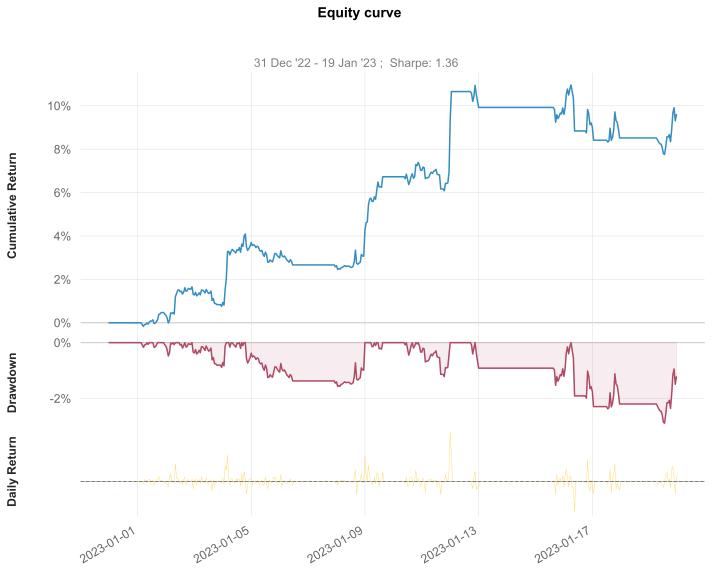

In [106]:
from tradeexecutor.utils.notebook import setup_charting_and_output
setup_charting_and_output()


# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset

In [107]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "BB long short mean reversion strategy - Own data",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=700
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance

In [108]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance


In [109]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state, time_bucket = CANDLE_TIME_BUCKET)

# with pd.option_context("display.max_row", None):
#      display(summary.to_dataframe())

summary.display()

,
Returns,
Annualised return %,193.22%
Lifetime return %,9.59%
Realised PnL,"$4,260.22"
Unrealised PnL,$537.19
Trade period,18 days 3 hours
,
Holdings,
Total assets,"$54,797.40"
Cash left,"$10,852.04"


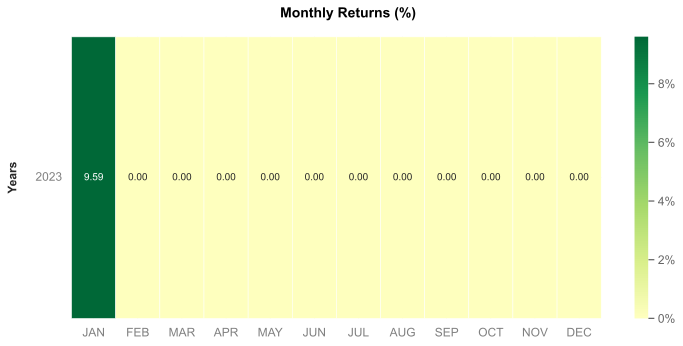

In [110]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

In [111]:
from IPython.core.display_functions import display

summary_by_side = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=CANDLE_TIME_BUCKET)

display(summary_by_side)

,All,Long,Short
Trading period length,18 days 3 hours,-,-
Return %,9.59%,9.59%,0.00%
Annualised return %,193.22%,193.22%,-
Cash at start,"$50,000.00",-,-
Value at end,"$54,797.40",-,-
Trade volume,"$893,577.33","$893,577.33",$0.00
Position win percent,50.00%,50.00%,-
Total positions,10,10,0
Won positions,5,5,0
Lost positions,5,5,0


In [112]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

,Strategy
Start Period,2023-01-01
End Period,2023-01-19
Risk-Free Rate,0.0%
Time in Market,58.0%
Cumulative Return,9.59%
CAGR﹪,540.99%
Sharpe,1.63
Prob. Sharpe Ratio,97.78%
Smart Sharpe,1.36
Sortino,3.07


### Position and trade timeline

Display all positions and how much profit they made.

In [113]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))

Remarks,Type,Opened at,Duration,Exchange,Base asset,Quote asset,Position max value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees
SL,Long,2023-01-01,2 days 15 hours,Uniswap v3,WETH,USDC,"$40,000.00",$418.15,1.05%,"$1,193.861514","$1,206.341775",2,$40.22
SL,Long,2023-01-03,1 days 11 hours,Uniswap v3,WETH,USDC,"$40,334.52","$1,153.56",2.86%,"$1,212.267119","$1,246.937816",2,$40.92
SL,Long,2023-01-05,1 days,Uniswap v3,WETH,USDC,"$41,257.37",$-238.59,-0.58%,"$1,251.810187","$1,244.571002",2,$41.15
TP,Long,2023-01-07,1 days 16 hours,Uniswap v3,WETH,USDC,"$41,066.50","$2,032.09",4.95%,"$1,263.000461","$1,325.497345",2,$42.09
SL,Long,2023-01-10,1 days 6 hours,Uniswap v3,WETH,USDC,"$42,692.17",$-280.83,-0.66%,"$1,330.676685","$1,321.923508",2,$42.56
TP,Long,2023-01-11,6 hours,Uniswap v3,WETH,USDC,"$42,467.50","$2,244.26",5.28%,"$1,337.480130","$1,408.161171",2,$43.60
SL,Long,2023-01-12,6 hours,Uniswap v3,WETH,USDC,"$44,262.91",$-365.85,-0.83%,"$1,428.298762","$1,416.493461",2,$44.09
SL,Long,2023-01-15,17 hours,Uniswap v3,WETH,USDC,"$43,970.23",$-541.84,-1.23%,"$1,557.496508","$1,538.303675",2,$43.71
SL,Long,2023-01-16,6 hours,Uniswap v3,WETH,USDC,"$43,536.76",$-212.80,-0.49%,"$1,572.676971","$1,564.990008",2,$43.44
SL,Long,2023-01-17,10 hours,Uniswap v3,WETH,USDC,"$43,366.52",$52.07,0.12%,"$1,570.948064","$1,572.834160",2,$43.40


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [114]:
print("All ok")

All ok
